In [1]:
pip install statsmodels openpyxl tabulate

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
import seaborn as sns

In [3]:
file_path = os.path.join('..', 'data', 'IMDB_movies_data.xlsx')
df = pd.read_excel(file_path)
df.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


In [4]:
df['Gross'] = df['Gross'].str.replace(",","").astype(float)
df['Runtime'] = df['Runtime'].str.strip("min").astype(float)

Checking coumns with NA Values

In [5]:
df.isna().any()

Poster_Link      False
Series_Title     False
Released_Year    False
Certificate       True
Runtime          False
Genre            False
IMDB_Rating      False
Overview         False
Meta_score        True
Director         False
Star1            False
Star2            False
Star3            False
Star4            False
No_of_Votes      False
Gross             True
dtype: bool

Deleting all the records with NAs would delete a lot of information from our data. I will fill NAs in certificate with "Unrated". NAs in Meta_score and Gross will be filled with KNN alghoritm using columns which are correlated with each feature. It will be more accurate than filling it with median or average.

In [6]:
df['Certificate'] = df['Certificate'].fillna("Unrated")

Before I start dealing with NAs I would like to prepare correlation matrix. During preparation I found out that adding Released_year returns error because of the mistake in one row.

In [7]:
df = df[df['Released_Year'].apply(lambda x: isinstance(x, int) or (isinstance(x, str) and x.isdigit()))]

#Convert 'Released_Year' to float
df['Released_Year'] = df['Released_Year'].astype(float)

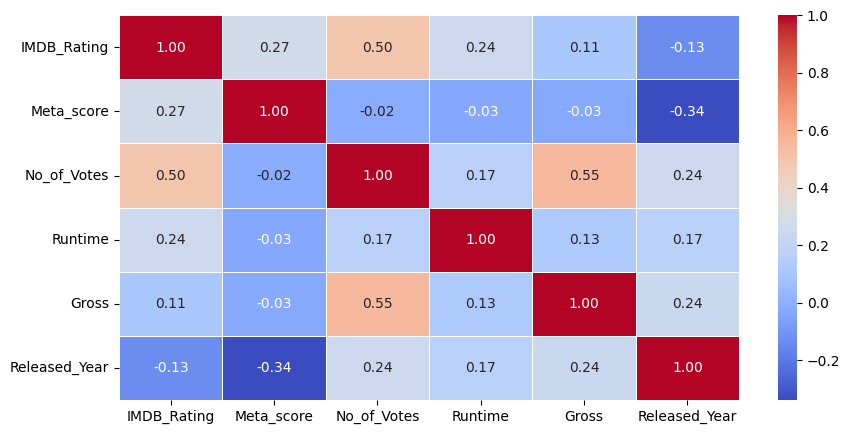

In [8]:
corr = df[['IMDB_Rating','Meta_score','No_of_Votes','Runtime','Gross','Released_Year']].corr()
corr.style.background_gradient(cmap='coolwarm')
# Create a correlation matrix plot with a color gradient
plt.figure(figsize=(10, 5))  
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# saving the plot
file_path_photos = os.path.join('..', 'photos','macierz_korelacji.png')
plt.savefig(file_path_photos, dpi=300, bbox_inches='tight')
plt.show()

We can see that Metascore is mostly correlated with IMDB_Rating and Released_Year and Gross is mostly correlated with No_of_Votes

In [9]:
from sklearn.impute import KNNImputer
# Impute Meta_score based on IMDB_Rating and released year
meta_imputer = KNNImputer(n_neighbors=5)
meta_imputed = meta_imputer.fit_transform(df[['IMDB_Rating','Released_Year', 'Meta_score']])

# Update Meta_score with the imputed values
df['Meta_score'] = meta_imputed[:, 2]

# Impute Gross based on No_of_Votes
gross_imputer = KNNImputer(n_neighbors=5)
gross_imputed = gross_imputer.fit_transform(df[['No_of_Votes', 'Gross']])

# Update Gross with the imputed values
df['Gross'] = gross_imputed[:, 1]

In [10]:
# We can start plotting data since we ended preprocessing.

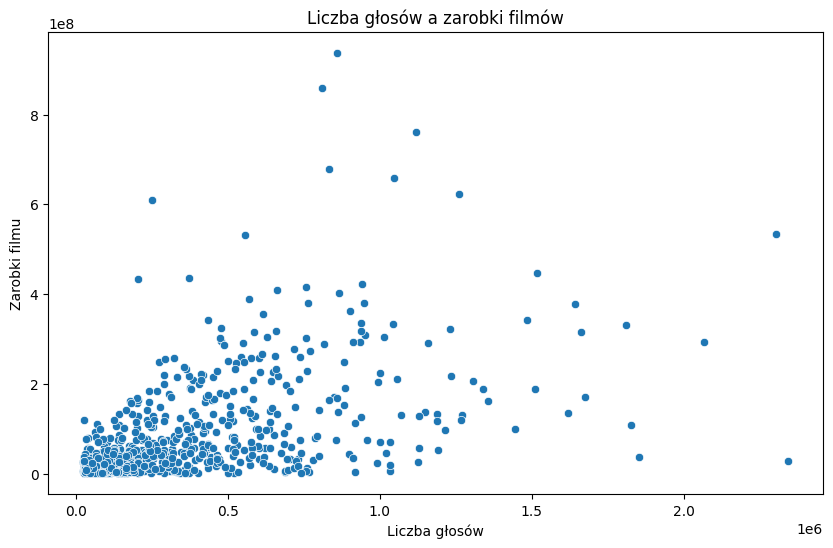

In [11]:
# Plotting the votes against earnings of the film
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['No_of_Votes'], y=df['Gross'])
plt.title('Liczba głosów a zarobki filmów')
plt.xlabel('Liczba głosów')
plt.ylabel('Zarobki filmu')
file_path_photos = os.path.join('..', 'photos','liczba_glosow_vs_zarobki.png')
plt.savefig(file_path_photos, dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# There are to many genres of films so I want to extract the main_genre

In [13]:
df['main_genre'] = df['Genre'].str.split(pat=",").str[0]

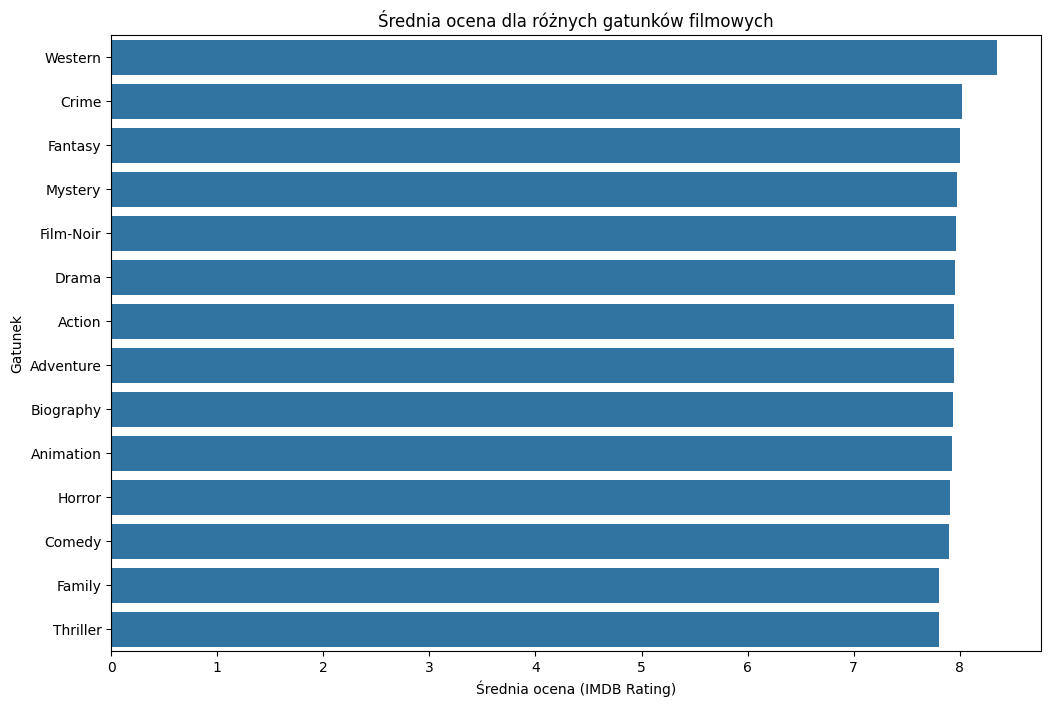

In [14]:
#Plotting average rating for different genres
genre_avg = df.groupby('main_genre')['IMDB_Rating'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=genre_avg.values, y=genre_avg.index)
plt.title('Średnia ocena dla różnych gatunków filmowych')
plt.xlabel('Średnia ocena (IMDB Rating)')
plt.ylabel('Gatunek')
file_path_photos = os.path.join('..', 'photos','srednia_ocena_gatunki.png')
plt.savefig(file_path_photos, dpi=300, bbox_inches='tight')

plt.show()

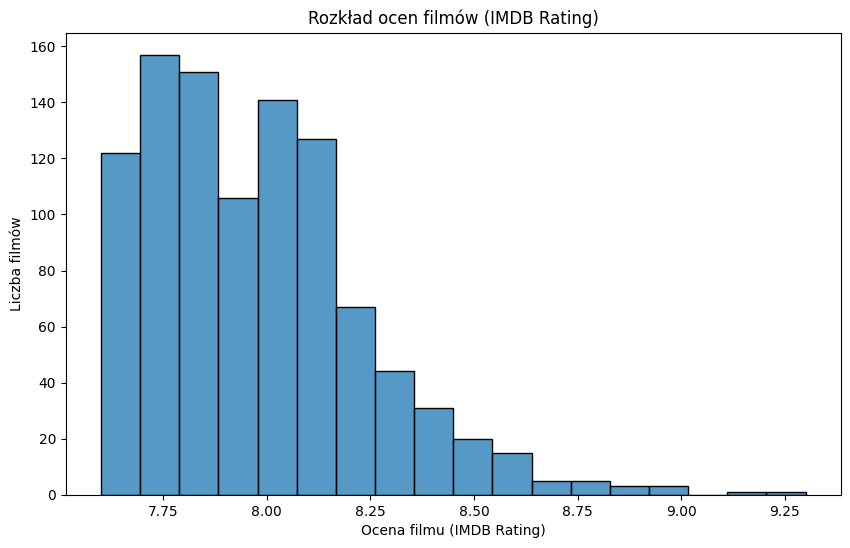

In [15]:
#plotting distribution of film rating
plt.figure(figsize=(10, 6))
sns.histplot(df['IMDB_Rating'], bins=18)
plt.title('Rozkład ocen filmów (IMDB Rating)')
plt.xlabel('Ocena filmu (IMDB Rating)')
plt.ylabel('Liczba filmów')
file_path_photos = os.path.join('..', 'photos','rozkład ocen filmów.png')
plt.savefig(file_path_photos, dpi=300, bbox_inches='tight')
plt.show()

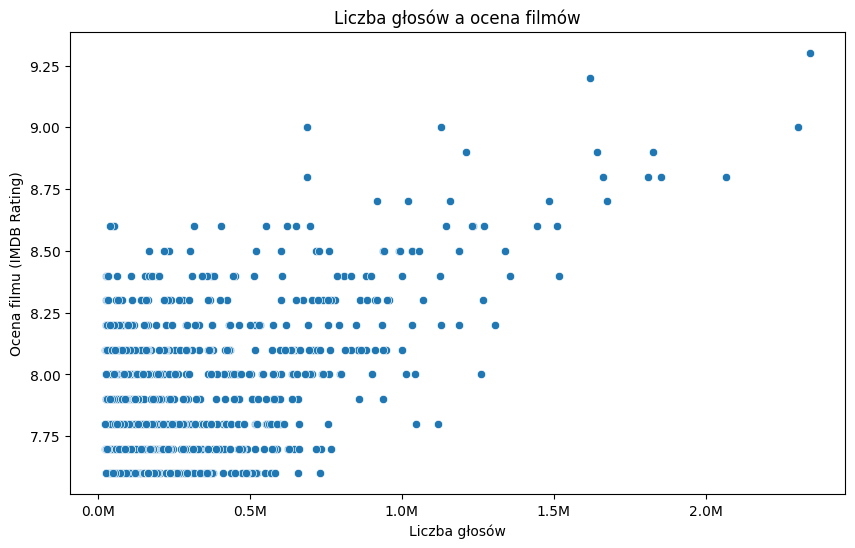

In [16]:
# plotting number of votes against the IMDB_Rating
from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    """Formatter function to display numbers in millions"""
    return f'{float(x / 1e6):,}M'  # Display in millions with 'M' suffix
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['No_of_Votes'], y=df['IMDB_Rating'])
plt.title('Liczba głosów a ocena filmów')
plt.xlabel('Liczba głosów')
plt.ylabel('Ocena filmu (IMDB Rating)')
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
file_path_photos = os.path.join('..', 'photos','liczba głosów a ocena filmu.png')
plt.savefig(file_path_photos, dpi=300, bbox_inches='tight')
plt.show()

In [17]:
# Filtering of films with less than 500000 votes but a rating greater than 8.4
high_rating_low_votes = df['Series_Title'][(df['No_of_Votes'] < 500000) & (df['IMDB_Rating'] > 8.4)]
high_rating_low_votes

18                        Hamilton
20                 Soorarai Pottru
30                         Seppuku
31            Shichinin no samurai
32           It's a Wonderful Life
45           Nuovo Cinema Paradiso
46                  Hotaru no haka
48    Once Upon a Time in the West
51                    Modern Times
52                     City Lights
Name: Series_Title, dtype: object

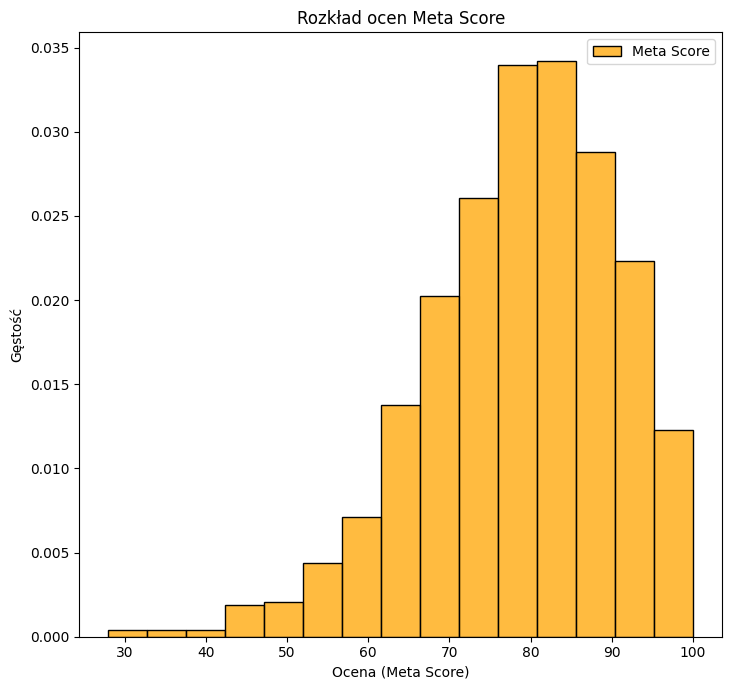

In [18]:
# histogram for metascore
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 2)
sns.histplot(df['Meta_score'], bins=15, kde=False, color='orange', stat="density", label='Meta Score')
plt.title('Rozkład ocen Meta Score')
plt.xlabel('Ocena (Meta Score)')
plt.ylabel('Gęstość')
plt.legend()
plt.tight_layout()
file_path_photos = os.path.join('..', 'photos','Rozkład ocen Meta score.png')
plt.savefig(file_path_photos, dpi=300, bbox_inches='tight')
plt.show()

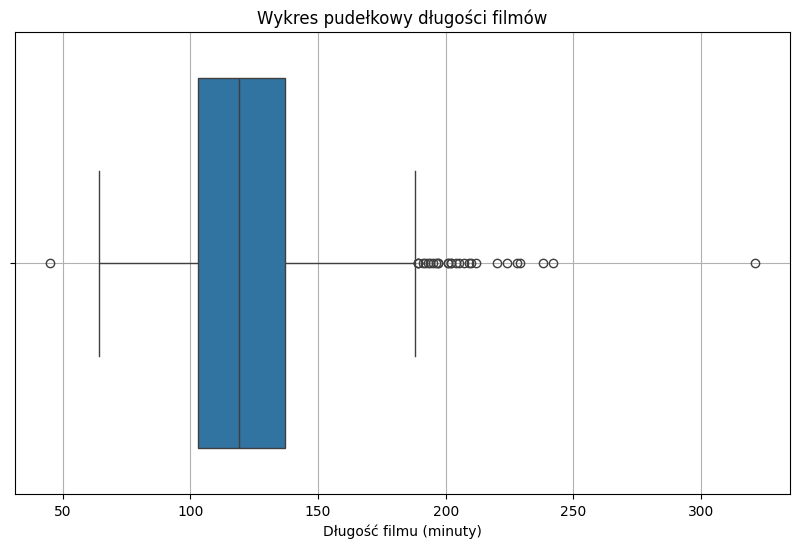

In [19]:
# plotting the runtime
plt.figure(figsize=(10, 6))
sns.boxplot(x='Runtime', data=df)
plt.title('Wykres pudełkowy długości filmów')
plt.xlabel('Długość filmu (minuty)')
plt.grid()
plt.show()

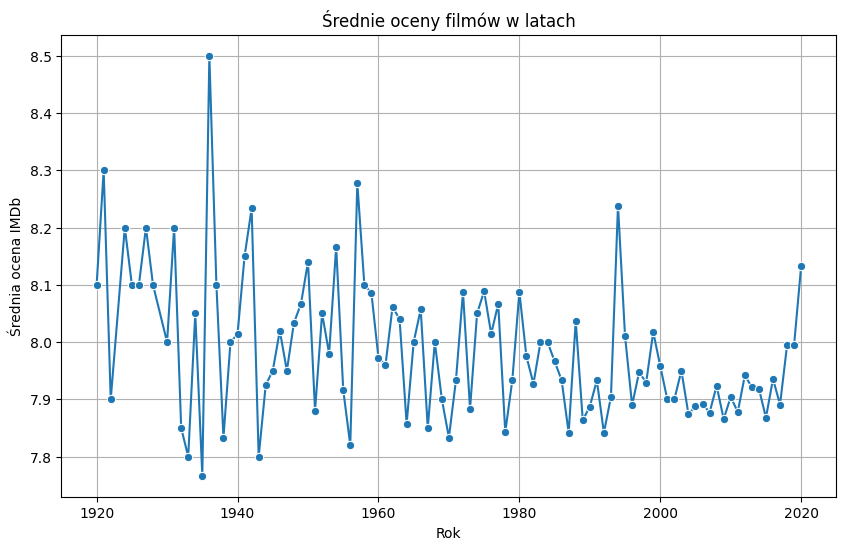

In [20]:
# counting average rating based on year
mean_ratings_per_year = df.groupby('Released_Year')['IMDB_Rating'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='Released_Year', y='IMDB_Rating', data=mean_ratings_per_year, marker='o')
plt.title('Średnie oceny filmów w latach')
plt.xlabel('Rok')
plt.ylabel('Średnia ocena IMDb')
plt.grid()
file_path_photos = os.path.join('..', 'photos','średnie oceny filmów na przestrzeni lat.png')
plt.savefig(file_path_photos, dpi=300, bbox_inches='tight')
plt.show()

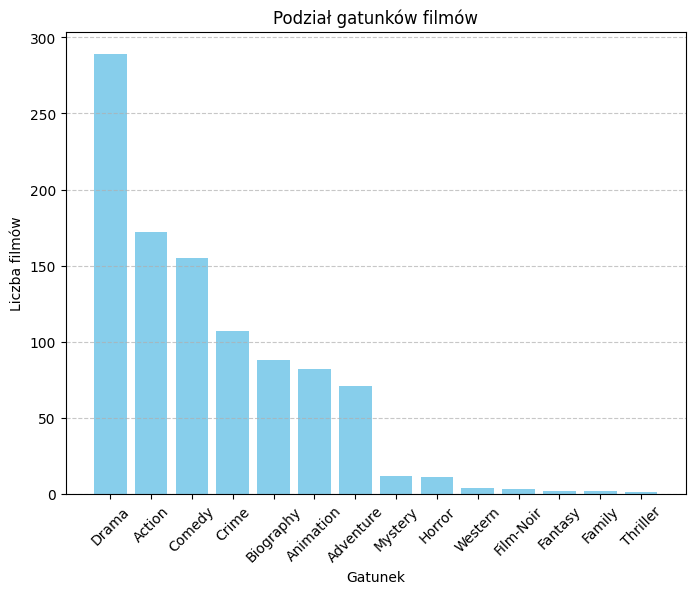

In [21]:
#number of genres
genre_counts = df['main_genre'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(genre_counts.index, genre_counts.values, color='skyblue')  # Corrected arguments
plt.title('Podział gatunków filmów')
plt.xlabel('Gatunek')
plt.ylabel('Liczba filmów')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for clarity
file_path_photos = os.path.join('..', 'photos','Których gatunków najwięcej.png')

plt.savefig(file_path_photos, dpi=300, bbox_inches='tight')
plt.show()

In [22]:
#average rating for each director
director_avg_rating = df.groupby('Director')['IMDB_Rating'].mean().sort_values(ascending=False)

# Wyświetlenie 10 reżyserów z najwyższymi średnimi ocenami
print(director_avg_rating.head(10))

Director
Frank Darabont        8.95
Lana Wachowski        8.70
Irvin Kershner        8.70
Masaki Kobayashi      8.60
Fernando Meirelles    8.60
George Lucas          8.60
Sudha Kongara         8.60
Thomas Kail           8.60
Roberto Benigni       8.60
Milos Forman          8.50
Name: IMDB_Rating, dtype: float64


In [23]:
# Grouping by directors who has more than 3 films
director_movie_count = df['Director'].value_counts()
directors_with_more_than_3_movies = director_movie_count[director_movie_count > 1].index

# Filtering directors with more than 3 films
directors_avg_rating = df[df['Director'].isin(directors_with_more_than_3_movies)].groupby('Director')['IMDB_Rating'].mean().sort_values(ascending=False)

# Showing the 10 directors with the highest average ratings
directors_avg_rating.head(10)

Director
Frank Darabont          8.950000
Milos Forman            8.500000
Christopher Nolan       8.462500
Francis Ford Coppola    8.400000
Peter Jackson           8.400000
Charles Chaplin         8.333333
Fritz Lang              8.300000
Nitesh Tiwari           8.300000
Lee Unkrich             8.300000
Sergio Leone            8.266667
Name: IMDB_Rating, dtype: float64

In [24]:
# We count the average ratings for actors
actors = pd.concat([df[['Star1', 'IMDB_Rating']].rename(columns={'Star1': 'Actor'}),
                    df[['Star2', 'IMDB_Rating']].rename(columns={'Star2': 'Actor'}),
                    df[['Star3', 'IMDB_Rating']].rename(columns={'Star3': 'Actor'}),
                    df[['Star4', 'IMDB_Rating']].rename(columns={'Star4': 'Actor'})])

# We calculate average ratings for actors
actor_avg_rating = actors.groupby('Actor')['IMDB_Rating'].mean().sort_values(ascending=False)

# Displaying the 10 actors with the highest average ratings
print(actor_avg_rating.head(10))

Actor
Bob Gunton          9.3
William Sadler      9.3
Aaron Eckhart       9.0
John Travolta       8.9
Caroline Goodall    8.9
Aldo Giuffrè        8.8
Elliot Page         8.8
Meat Loaf           8.8
Sean Bean           8.8
Gary Sinise         8.8
Name: IMDB_Rating, dtype: float64


In [25]:
numerical_columns = ['Released_Year', 'Runtime', 'Meta_score', 'No_of_Votes', 'Gross']
X = df[numerical_columns]
y = df['IMDB_Rating']


In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
import statsmodels.api as sm

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fitting the OLS model
model = sm.OLS(y_train, X_train_sm.astype(float))
results = model.fit()

# Displaying the summary of the regression model
summary = results.summary()
print(summary)

# Prediction and evaluation
y_pred = results.predict(X_test_sm)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Błąd średniokwadratowy (MSE) regresji: {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')

                            OLS Regression Results                            
Dep. Variable:            IMDB_Rating   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     134.3
Date:                Mon, 28 Oct 2024   Prob (F-statistic):          4.18e-103
Time:                        10:36:26   Log-Likelihood:                 129.07
No. Observations:                 799   AIC:                            -246.1
Df Residuals:                     793   BIC:                            -218.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            10.9444      0.729     15.012